In [8]:
import bt
import pandas as pd
import seaborn as sns
import datetime

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Downloading Historical data
First let's download some historical data from Poloniex. With this API you can only fetch one year at a time.

In [158]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
pairs = ['USDT_BTC','USDT_ETH', 'USDT_LTC']

def get_price_table(pair, start, end):
    """
    Poloniex API only returns maximum of 300000 trades or 1 year for each pair.
    :returns:
    dictionary with one dataframe per pair
    """
    print('Downloading {} from {} to {}.'.format(pair,start,end))
    
    df = pd.read_json('https://poloniex.com/public?command=returnTradeHistory&currencyPair={}&start={}&end={}'.format(pair, int(start.timestamp()), int(end.timestamp())))
    df.set_index(['date'], inplace=True)
    print('fetched {} {} trades.'.format(df.size,pair))
    df = df.resample('1T').mean() #resample in windows of 1 minute
    df[pair] = df.rate
    for cname in df.columns:
        if cname not in pairs:
            del df[cname]

    return df

def concatenate_series(rates):
    """
    :parameters:
    - rates: dictionary with the pairs dataframes
    """
    for k, df in rates.items(): #Solve non-unique indices
        rates[k] = df.loc[~df.index.duplicated(keep='first')]
    data = pd.concat(rates, axis=1)
    data.columns = data.columns.droplevel(0)
    print(data.columns)
    data.columns = [name.lower() for name in data.columns] #convenient to save to PGSQL
    return data

def extend_history(pair, df):
    End = df.index.min()
    Start = end - datetime.timedelta(days=364)
    dfextra = get_price_table(pair,Start,End)
    df = df.append(dfextra)#pd.concat([df,dfextra], axis=0)
    return df

### Downloading the data

In [152]:
rates = {pair: get_price_table(pair, start, end) for pair in pairs}

fetched 300000 USDT_BTC trades.
fetched 300000 USDT_ETH trades.
fetched 300000 USDT_LTC trades.


In [160]:
rates['USDT_ETH'].head()

,USDT_ETH
date,
2017-07-05 18:48:00,269.980000
2017-07-05 18:49:00,270.045142
2017-07-05 18:50:00,270.434781
2017-07-05 18:51:00,270.908357
2017-07-05 18:52:00,270.713774


In [129]:
rates['USDT_ETH'].tail()

,USDT_ETH
date,
2017-07-09 15:19:00,240.439428
2017-07-09 15:20:00,241.136930
2017-07-09 15:21:00,241.209091
2017-07-09 15:22:00,241.444967
2017-07-09 15:23:00,241.237650


### Extending our history

Now we can extend the series with 50000 extra trades for each pair. The series won't grow by this much because we are aggregating by minute.

In [164]:
rates = {pair: extend_history(pair, rates[pair]) for pair in rates}

fetched 300000 USDT_LTC trades.
fetched 300000 USDT_BTC trades.
fetched 300000 USDT_ETH trades.


In [165]:
rates['USDT_ETH'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15651 entries, 2017-07-05 18:48:00 to 2017-07-01 04:05:00
Data columns (total 1 columns):
USDT_ETH    14751 non-null float64
dtypes: float64(1)
memory usage: 244.5 KB


Index(['USDT_BTC', 'USDT_ETH', 'USDT_LTC'], dtype='object')


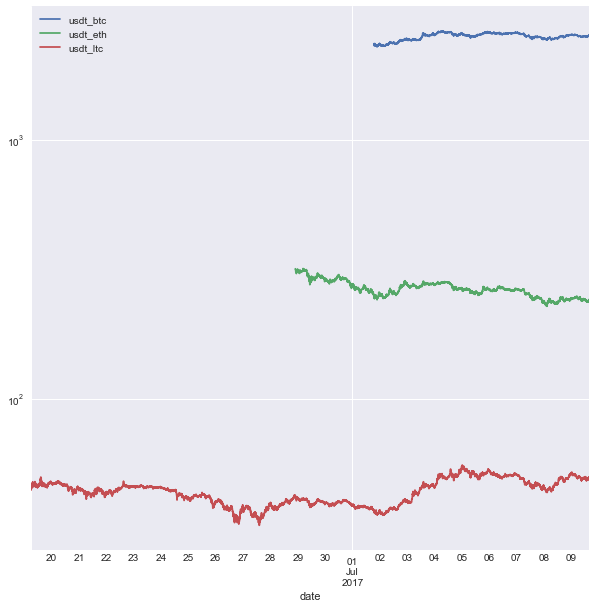

In [166]:
data = concatenate_series(rates)
data.plot(figsize=(10,10), logy=True);

In [145]:
data.head()

,usdt_btc,usdt_eth,usdt_ltc
date,,,
2017-07-05 08:32:00,NaN,NaN,51.769999
2017-07-05 08:33:00,NaN,NaN,51.734193
2017-07-05 08:34:00,NaN,NaN,51.803571
2017-07-05 08:35:00,NaN,NaN,51.816261
2017-07-05 08:36:00,NaN,NaN,51.865071


In [50]:
# create the strategy
s = bt.Strategy('s1', [bt.algos.RunWeekly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])


In [52]:
# create a backtest and run it
test = bt.Backtest(s, data)
res = bt.run(test)


s1
0% [##############################] 100% | ETA: 00:00:00

/usr/local/lib/python3.5/dist-packages/ffn/core.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  res = er.mean() / er.std()
/usr/local/lib/python3.5/dist-packages/ffn/core.py:209: RuntimeWarning: invalid value encountered in double_scalars
  self.calmar = self.cagr / abs(self.max_drawdown)


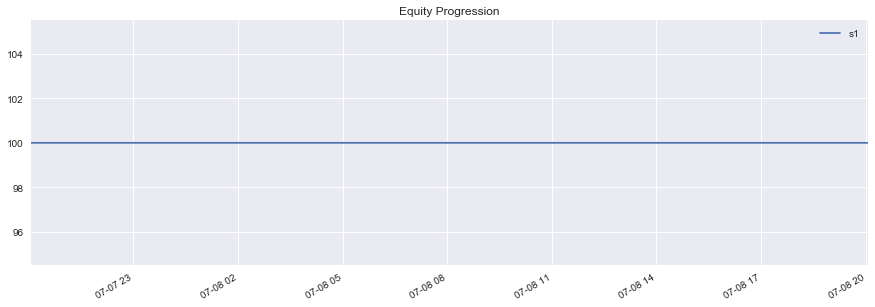

In [53]:
res.plot()


In [54]:
res.display()

Stat                 s1
-------------------  ----------
Start                2017-07-07
End                  2017-07-07
Risk-free rate       0.00%

Total Return         0.00%
Daily Sharpe         -
Daily Sortino        -
CAGR                 0.00%
Max Drawdown         0.00%
Calmar Ratio         -

MTD                  -
3m                   -
6m                   -
YTD                  0.00%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  0.00%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    0.00%
Daily Vol (ann.)     0.00%
Daily Skew           0.00
Daily Kurt           -
Best Day             0.00%
Worst Day            0.00%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly Skew         -
Monthly Kurt         -
Best Month           -
Worst Month          -

Yearly Sharpe        -
Yearly Sortino       -
Yearly Mean          -
Yearly Vol           -
Year